# Random Forrest

## Prepare for modelling

### Import libraries and read data

In [160]:
import pandas as pd 
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import sys
sys.path.append("..")
import mlflow
from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open("../.mlflow_uri").read().strip()

from yellowbrick.regressor import ResidualsPlot

In [2]:
# read data
df = pd.read_csv('../data/Featureselection03.csv')
df.head()

,EntryDate,AB.FMS.act.tPh,AB.FTS.act.dgC,DDM.AFTCL.act.m,DDM.FWDCL.act.m,DDM.MIDPS.act.m,DDM.MIDSB.act.m,HFO.GME.act.nodim,ME.EFF.act.PRC,ME.FMS.act.tPh,...,Heading_Dir_deg_daily,True_Wind_Speed_mPs_daily,True_Wind_Dir_deg_daily,Wave_Height_m_daily,True_Wave_Dir_deg_daily,trip_id,Power_EM_predict,DDM.TRIM.act.m,DDM.DRAFT.act.m,DDM.HEEL.act.m
0,2021-05-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80.0,6.7,109.0,0.5,289.0,1,14579.22,1.021,0.1276,0.2552
1,2021-05-31 00:01:00,0.003108,82.858482,13.309999,14.788999,13.924999,13.587000,1.0,50.766113,3.353553,...,80.0,6.7,109.0,0.5,289.0,2,14579.22,1.021,0.1276,0.2552
2,2021-05-31 00:02:00,0.001970,82.832756,13.444999,14.363999,13.320999,13.378999,1.0,50.982193,3.305582,...,80.0,6.7,109.0,0.5,289.0,2,14579.22,1.021,0.1276,0.2552
3,2021-05-31 00:03:00,0.000000,82.795395,13.381999,14.321000,14.242000,13.584000,1.0,51.326881,3.288588,...,80.0,6.7,109.0,0.5,289.0,2,14579.22,1.021,0.1276,0.2552
4,2021-05-31 00:04:00,0.000000,82.884254,13.365999,14.745000,14.094998,13.596999,1.0,52.311672,3.239272,...,80.0,6.7,109.0,0.5,289.0,2,14579.22,1.021,0.1276,0.2552


In [3]:
# read list with feature importance
data_log = pd.read_csv('../data/Capstone_features_Features.csv')
data_log.head()

,VarName,F_Imp_new,ModelImportance
0,LM1.plc_skewtime.act.s,3,3
1,LM1.plc_skewtime.max.s,3,3
2,LM1.plc_uptime.act.s,3,3
3,LM1.plc_cpuload.avg_5s.PRC,3,3
4,LM1.plc_timeBalance.act.s,3,3


### Create data frame with important features

In [4]:
# create list of important features (feature importance < 3)
list_imp_feat = list(data_log[data_log['ModelImportance'] < 3]['VarName'])
len(list_imp_feat)

18

In [5]:
df_model = df[list_imp_feat].copy()

In [6]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211679 entries, 0 to 211678
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ME.FMS.act.tPh           210961 non-null  float64
 1   ME.FTS.act.dgC           210961 non-null  float64
 2   HFO.GME.act.nodim        210961 non-null  float64
 3   V.COG.act.deg            210885 non-null  float64
 4   V.SOG.act.kn             210885 non-null  float64
 5   V.RUA.act.deg            210885 non-null  float64
 6   V.GPSLAT.act.deg         210885 non-null  float64
 7   V.GPSLON.act.deg         210885 non-null  float64
 8   WEA.WDT.act.deg          210814 non-null  float64
 9   WEA.WST.act.mPs          210884 non-null  float64
 10  V.SLPOG.act.PRC          136969 non-null  float64
 11  ME.SFCI.act.gPkWh        136929 non-null  float64
 12  DDM.TRIM.act.m           211679 non-null  float64
 13  DDM.DRAFT.act.m          211679 non-null  float64
 14  pass

### Fill and drop NaN, remove outlier

In [7]:
df_model['V.SLPOG.act.PRC'].fillna(0,inplace=True)
df_model['ME.SFCI.act.gPkWh'].fillna(0,inplace=True)

In [8]:
df_model.dropna(inplace=True)

In [29]:
df_model = df_model[df_model['ME.FMS.act.tPh']<8]

In [30]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180148 entries, 1 to 211678
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ME.FMS.act.tPh           180148 non-null  float64
 1   ME.FTS.act.dgC           180148 non-null  float64
 2   HFO.GME.act.nodim        180148 non-null  float64
 3   V.COG.act.deg            180148 non-null  float64
 4   V.SOG.act.kn             180148 non-null  float64
 5   V.RUA.act.deg            180148 non-null  float64
 6   V.GPSLAT.act.deg         180148 non-null  float64
 7   V.GPSLON.act.deg         180148 non-null  float64
 8   WEA.WDT.act.deg          180148 non-null  float64
 9   WEA.WST.act.mPs          180148 non-null  float64
 10  V.SLPOG.act.PRC          180148 non-null  float64
 11  ME.SFCI.act.gPkWh        180148 non-null  float64
 12  DDM.TRIM.act.m           180148 non-null  float64
 13  DDM.DRAFT.act.m          180148 non-null  float64
 14  pass

### Check correlations

<AxesSubplot:>

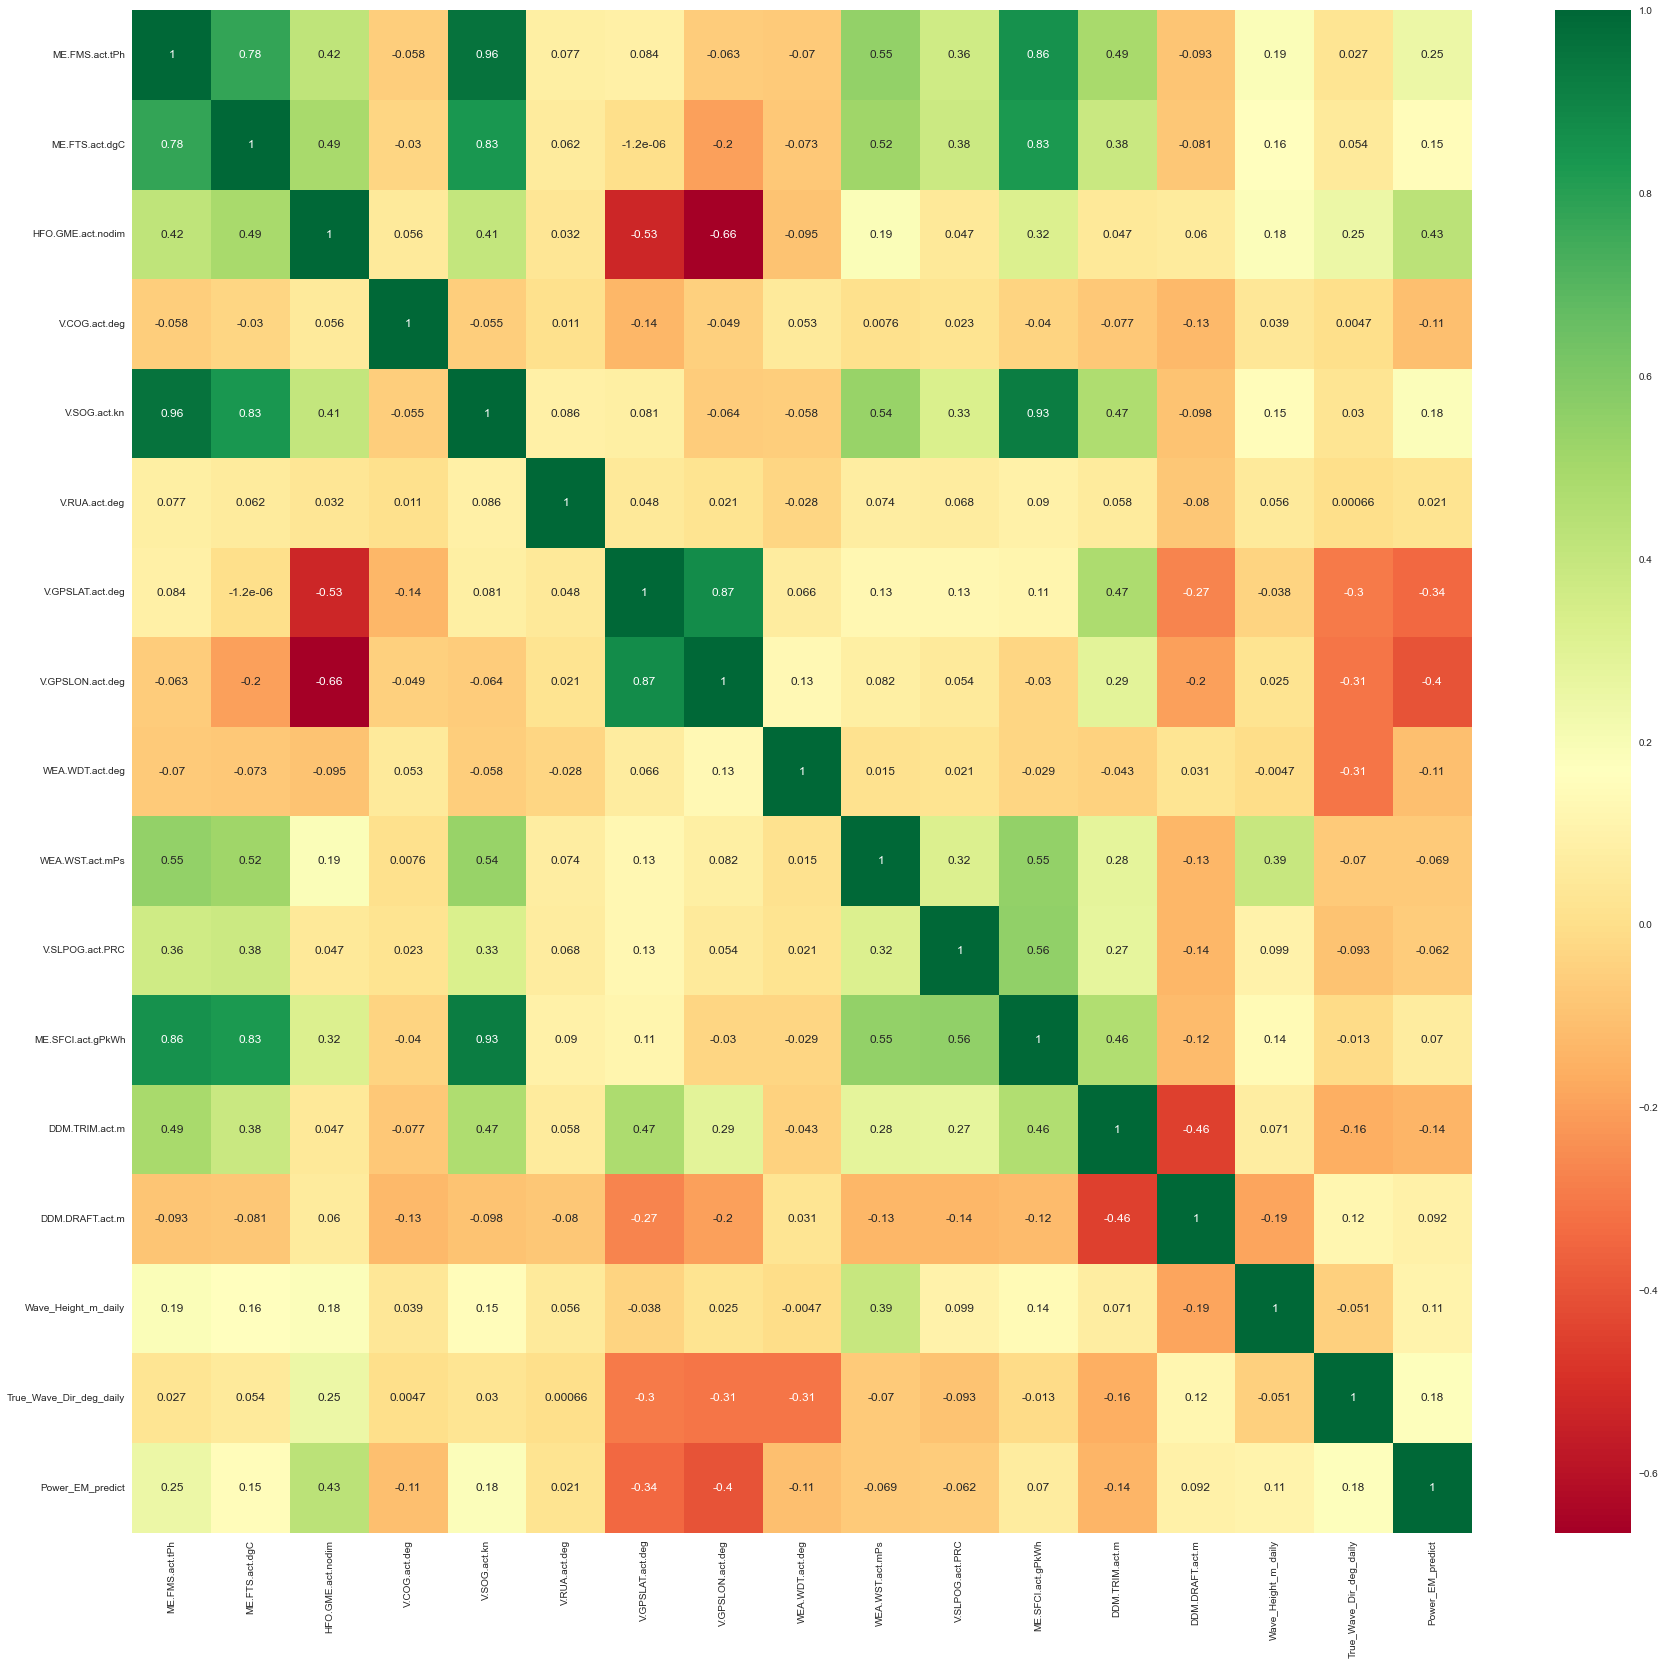

In [31]:
plt.figure(figsize = (30,28))
sns.heatmap(df_model.corr(), annot = True, cmap = 'RdYlGn')

### Define target

In [32]:
X = df_model.drop(['ME.FMS.act.tPh'], axis = 1)
y = df_model['ME.FMS.act.tPh']

### Train Test Split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = X['passage_type'], test_size = 0.1, random_state = 42)

### Create dummy values for passage type

In [34]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

## Set MLFlow connection

In [121]:
# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.start_run(run_name='RandomForrest') 
run = mlflow.active_run()

## Modelling (n_estimators=100,max_features = 'sqrt')

### Pipeline

In [35]:
forest = make_pipeline(MinMaxScaler(), RandomForestRegressor(random_state=42,n_estimators=100,max_features = 'sqrt',n_jobs=-1, verbose = 1))

### Fit and predict

In [36]:
forest.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.3s finished


Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_features='sqrt', n_jobs=-1,
                                       random_state=42, verbose=1))])

In [37]:
y_pred = forest.predict(X_test)
y_pred_train = forest.predict(X_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.1s finished


### RMSE

In [38]:
print('RMSE train: ', mean_squared_error(y_train, y_pred_train, squared= False))
rmse_train = mean_squared_error(y_train, y_pred_train, squared= False)
print('RMSE test: ', mean_squared_error(y_test, y_pred, squared= False))
rmse_test = mean_squared_error(y_test, y_pred, squared= False)

RMSE train:  0.027324117878567426
RMSE test:  0.07499158951915391


### Plot

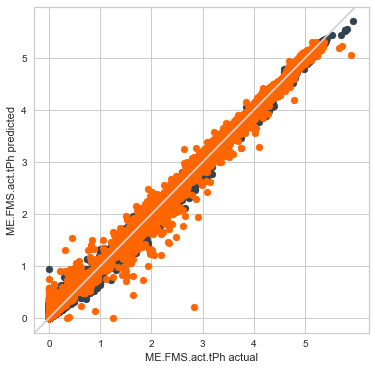

In [40]:
fig=plt.figure(figsize=(6, 6))
plt.axline([1, 1], [2, 2],color='lightgrey')
plt.scatter(y_train, y_pred_train, color ='#33424F')
plt.scatter(y_test, y_pred, color = '#FF6600')
plt.xticks(np.arange(0,6,1));
plt.yticks(np.arange(0,6,1));
plt.xlabel("ME.FMS.act.tPh actual");
plt.ylabel("ME.FMS.act.tPh predicted");

/Users/rweil/neue_fische/capstone_ml_shipping/.venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n

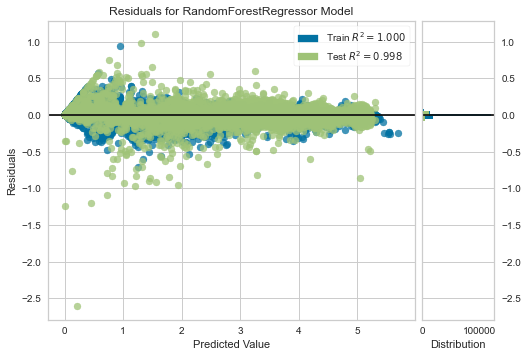

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [41]:
visualizer = ResidualsPlot(forest)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  

### Write to MLFlow

In [23]:
#seting parameters that should be logged on MLFlow
#these parameters were used in feature engineering (inputing missing values)
#or parameters of the model (fit_intercept for Linear Regression model)
params = {
      "features drop": 'According to model importance list',
      'n_estimators': 100,
      'max_features': 'sqrt',
      "csv used": 'Featureselection03.csv',
      "NaN handling": 'V.SLPOG.act.PRC and ME.SFCI.act.gPkWh filled with 0, rest dropped by row',
      'Shape' : df.shape,
      'Scaler' : 'MinMaxScaler'
  }

In [24]:
#logging params to mlflow
mlflow.log_params(params)
#setting tags
mlflow.set_tag("running_from_jupyter", "True")
#logging metrics
mlflow.log_metric("train-" + "RMSE", rmse_train)
mlflow.log_metric("test-" + "RMSE", rmse_test)
# logging the model to mlflow will not work without a AWS Connection setup.. too complex for now
# but possible if running mlflow locally
# mlflow.log_artifact("../models")
# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

## Modelling (Grid Search)

### Pipeline

In [42]:
forest2 = make_pipeline(MinMaxScaler(), RandomForestRegressor())

### Grid Search

In [52]:
# Grid search for Decision Tree

# Defining parameter grid (as dictionary)
param_grid = {'randomforestregressor__n_estimators':[250],
              'randomforestregressor__criterion':['squared_error'],
              'randomforestregressor__max_depth':[30],
              'randomforestregressor__min_samples_split':[20],
              'randomforestregressor__max_features':['auto','sqrt'],
              'randomforestregressor__max_leaf_nodes':[1000,1100],
              'randomforestregressor__random_state': [42]
             }

# Instantiate gridsearch and define the metric to optimize 
gs_forest = GridSearchCV(forest2, param_grid, scoring='neg_root_mean_squared_error', cv=5, verbose=2, n_jobs=-1)


### Fit and predict

In [54]:
gs_forest.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END randomforestregressor__criterion=squared_error, randomforestregressor__max_depth=30, randomforestregressor__max_features=auto, randomforestregressor__max_leaf_nodes=1000, randomforestregressor__min_samples_split=20, randomforestregressor__n_estimators=250, randomforestregressor__random_state=42; total time= 9.8min
[CV] END randomforestregressor__criterion=squared_error, randomforestregressor__max_depth=30, randomforestregressor__max_features=auto, randomforestregressor__max_leaf_nodes=1000, randomforestregressor__min_samples_split=20, randomforestregressor__n_estimators=250, randomforestregressor__random_state=42; total time= 9.8min
[CV] END randomforestregressor__criterion=squared_error, randomforestregressor__max_depth=30, randomforestregressor__max_features=auto, randomforestregressor__max_leaf_nodes=1000, randomforestregressor__min_samples_split=20, randomforestregressor__n_estimators=250, randomforestregressor__r

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__criterion': ['squared_error'],
                         'randomforestregressor__max_depth': [30],
                         'randomforestregressor__max_features': ['auto',
                                                                 'sqrt'],
                         'randomforestregressor__max_leaf_nodes': [1000, 1100],
                         'randomforestregressor__min_samples_split': [20],
                         'randomforestregressor__n_estimators': [250],
                         'randomforestregressor__random_state': [42]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [55]:
# Show best parameters
print('Best score:\n{:.2f}'.format(gs_forest.best_score_))
print("Best parameters:\n{}".format(gs_forest.best_params_))

Best score:
-0.08
Best parameters:
{'randomforestregressor__criterion': 'squared_error', 'randomforestregressor__max_depth': 30, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_leaf_nodes': 1100, 'randomforestregressor__min_samples_split': 20, 'randomforestregressor__n_estimators': 250, 'randomforestregressor__random_state': 42}


In [56]:
y_pred = gs_forest.predict(X_test)
y_pred_train = gs_forest.predict(X_train)

### RMSE

In [57]:
print('RMSE train: ', mean_squared_error(y_train, y_pred_train, squared= False))
rmse_train = mean_squared_error(y_train, y_pred_train, squared= False)
print('RMSE test: ', mean_squared_error(y_test, y_pred, squared= False))
rmse_test = mean_squared_error(y_test, y_pred, squared= False)

RMSE train:  0.06419755049974117
RMSE test:  0.08357333979073497


### Plot

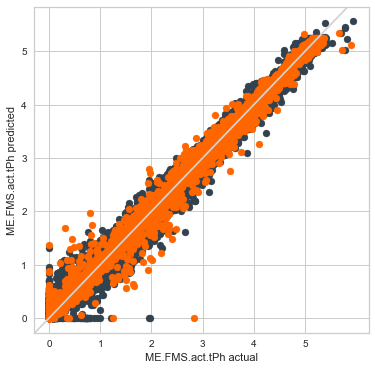

In [58]:
fig=plt.figure(figsize=(6, 6))
plt.axline([1, 1], [2, 2],color='lightgrey')
plt.scatter(y_train, y_pred_train, color ='#33424F')
plt.scatter(y_test, y_pred, color = '#FF6600')
plt.xticks(np.arange(0,6,1));
plt.yticks(np.arange(0,6,1));
plt.xlabel("ME.FMS.act.tPh actual");
plt.ylabel("ME.FMS.act.tPh predicted");

/Users/rweil/neue_fische/capstone_ml_shipping/.venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


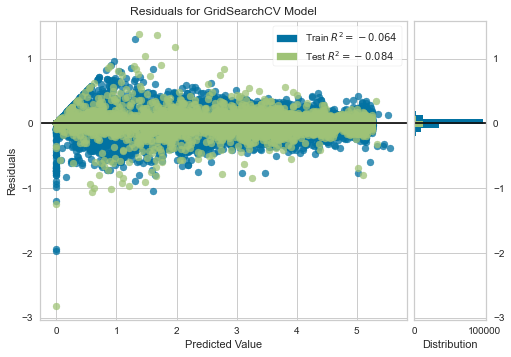

<AxesSubplot:title={'center':'Residuals for GridSearchCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [59]:
visualizer = ResidualsPlot(gs_forest)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  

## Modelling (Random Forest final)

### Pipeline

In [115]:
forest3 = make_pipeline(MinMaxScaler(), 
                        RandomForestRegressor(criterion= 'squared_error',
                                            max_depth= 40, 
                                            max_features= 'auto',
                                            max_leaf_nodes= 7000, 
                                            min_samples_split= 20,
                                            n_estimators= 100, 
                                            random_state= 42))

### Fit and predict

In [116]:
forest3.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=40, max_leaf_nodes=7000,
                                       min_samples_split=20,
                                       random_state=42))])

In [117]:
y_pred = forest3.predict(X_test)
y_pred_train = forest3.predict(X_train)

### RMSE

In [118]:
print('RMSE train: ', mean_squared_error(y_train, y_pred_train, squared= False))
rmse_train = mean_squared_error(y_train, y_pred_train, squared= False)
print('RMSE test: ', mean_squared_error(y_test, y_pred, squared= False))
rmse_test = mean_squared_error(y_test, y_pred, squared= False)

RMSE train:  0.049372115495081116
RMSE test:  0.07874091983930853


### Plot

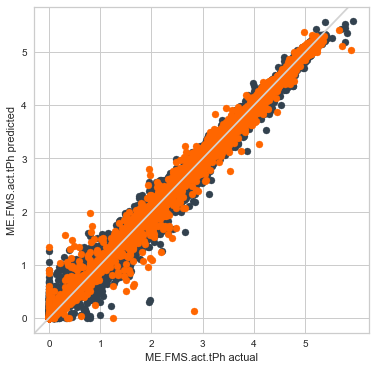

In [119]:
fig=plt.figure(figsize=(6, 6))
plt.axline([1, 1], [2, 2],color='lightgrey')
plt.scatter(y_train, y_pred_train, color ='#33424F')
plt.scatter(y_test, y_pred, color = '#FF6600')
plt.xticks(np.arange(0,6,1));
plt.yticks(np.arange(0,6,1));
plt.xlabel("ME.FMS.act.tPh actual");
plt.ylabel("ME.FMS.act.tPh predicted");

/Users/rweil/neue_fische/capstone_ml_shipping/.venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


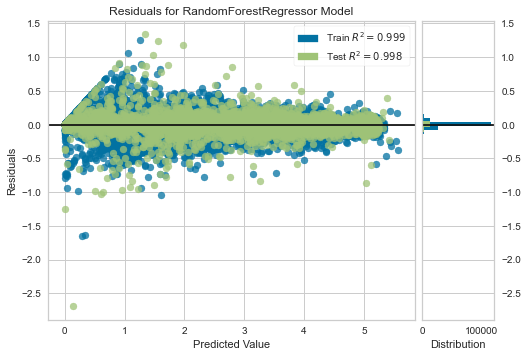

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [120]:
visualizer = ResidualsPlot(forest3)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  

### Write to MLFlow

In [122]:
#seting parameters that should be logged on MLFlow
#these parameters were used in feature engineering (inputing missing values)
#or parameters of the model (fit_intercept for Linear Regression model)
params = {
      "features drop": 'According to model importance list',
      "criterion": 'squared_error',
      'max_features': 'auto',
      "random_state": 42,
      "max_depth": 40,
      'max_leaf_nodes': 7000,
      'min_samples_split': 20,
      'n_estimators': 100,
      "csv used": 'Featureselection03.csv',
      "NaN handling": 'V.SLPOG.act.PRC and ME.SFCI.act.gPkWh filled with 0, rest dropped by row',
      'Shape' : df.shape,
      'Scaler' : 'MinMaxScaler'
  }

In [123]:
#logging params to mlflow
mlflow.log_params(params)
#setting tags
mlflow.set_tag("running_from_jupyter", "True")
#logging metrics
mlflow.log_metric("train-" + "RMSE", rmse_train)
mlflow.log_metric("test-" + "RMSE", rmse_test)
# logging the model to mlflow will not work without a AWS Connection setup.. too complex for now
# but possible if running mlflow locally
# mlflow.log_artifact("../models")
# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

### Important features

In [136]:
df_importance = pd.DataFrame({'features' : X_train.columns, 'importance' : forest3['randomforestregressor'].feature_importances_})
df_importance.sort_values('importance',ascending=False)

,features,importance
3,V.SOG.act.kn,8.853973e-01
15,Power_EM_predict,4.065362e-02
10,ME.SFCI.act.gPkWh,3.122750e-02
9,V.SLPOG.act.PRC,1.338717e-02
2,V.COG.act.deg,7.450463e-03
6,V.GPSLON.act.deg,4.968666e-03
8,WEA.WST.act.mPs,4.315626e-03
5,V.GPSLAT.act.deg,2.367560e-03
0,ME.FTS.act.dgC,2.144348e-03
11,DDM.TRIM.act.m,1.949423e-03


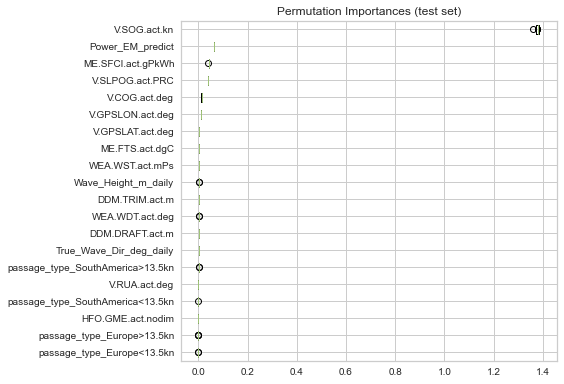

In [143]:
result = permutation_importance(
    forest3, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx]
)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

## False prediction of target = 0

In [152]:
df_result_train = X_train.copy()

In [153]:
df_result_train['predicted'] = y_pred_train
df_result_train['actual'] = y_train

In [158]:
df_target_zero_false = df_result_train[df_result_train['actual']<=0]
df_target_zero_false = df_target_zero_false[df_target_zero_false['predicted']>0.1]

In [159]:
df_target_zero_false

,ME.FTS.act.dgC,HFO.GME.act.nodim,V.COG.act.deg,V.SOG.act.kn,V.RUA.act.deg,V.GPSLAT.act.deg,V.GPSLON.act.deg,WEA.WDT.act.deg,WEA.WST.act.mPs,V.SLPOG.act.PRC,...,DDM.DRAFT.act.m,Wave_Height_m_daily,True_Wave_Dir_deg_daily,Power_EM_predict,passage_type_Europe<13.5kn,passage_type_Europe>13.5kn,passage_type_SouthAmerica<13.5kn,passage_type_SouthAmerica>13.5kn,predicted,actual
208003,60.858917,0.0,31.000000,0.889,35.700001,9.442134,-79.896866,326.928955,6.287233,103.653893,...,0.0262,1.0,79.0,6424.35,0,0,1,0,0.127835,0.0
87224,36.662109,0.0,328.899994,0.001,0.000000,51.948624,4.057535,344.500000,5.916060,0.000000,...,0.2620,0.2,299.0,13541.05,1,0,0,0,0.137138,0.0
131135,67.217102,1.0,154.300003,0.880,-0.100000,-12.052871,-77.148880,156.831955,8.799218,50.049667,...,0.0510,3.5,339.0,15780.69,0,0,1,0,0.489606,0.0
44874,66.105225,1.0,124.699997,2.386,0.000000,-12.049746,-77.151726,89.302185,2.049487,123.094543,...,0.1080,0.1,339.0,13374.00,0,0,1,0,0.376233,0.0
180923,63.605682,0.0,65.199997,3.429,-0.400000,53.969742,7.907341,150.499512,8.661499,53.655136,...,-0.0154,1.5,139.0,11249.03,1,0,0,0,0.287036,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49927,46.536255,1.0,82.099998,0.344,0.000000,-23.040384,-70.377892,38.872223,3.202462,51.335655,...,0.0759,1.0,329.0,11138.45,0,0,1,0,0.175223,0.0
38195,59.453369,0.0,172.800003,0.386,0.200000,9.266531,-79.911674,343.469543,0.711006,0.000000,...,-0.0790,0.3,9.0,33284.45,0,0,1,0,0.253519,0.0
208093,64.541138,0.0,98.300003,0.041,0.600000,9.366529,-79.885216,184.500000,1.286100,18.026699,...,0.0540,1.0,79.0,6424.35,0,0,1,0,0.397996,0.0
209543,51.867950,0.0,170.699997,1.720,0.500000,9.263090,-79.911140,187.085693,4.744702,0.000000,...,-0.0700,1.0,79.0,6424.35,0,0,1,0,0.326466,0.0


In [166]:
px.scatter(df_target_zero_false,x='V.SOG.act.kn',y='predicted',color='ME.SFCI.act.gPkWh')

In [167]:
px.scatter(df_target_zero_false,x='Power_EM_predict',y='predicted',color='ME.SFCI.act.gPkWh')

In [164]:
px.scatter(df_target_zero_false,x='ME.SFCI.act.gPkWh',y='predicted')

## Residuals >0.5 or <-0.5

In [169]:
df_result_train['residual'] = df_result_train['predicted'] - df_result_train['actual']

In [172]:
df_residual_high_pos = df_result_train[df_result_train['residual']>0.5]

In [173]:
df_residual_high_neg = df_result_train[df_result_train['residual']<-0.5]

<AxesSubplot:xlabel='V.SOG.act.kn', ylabel='predicted'>

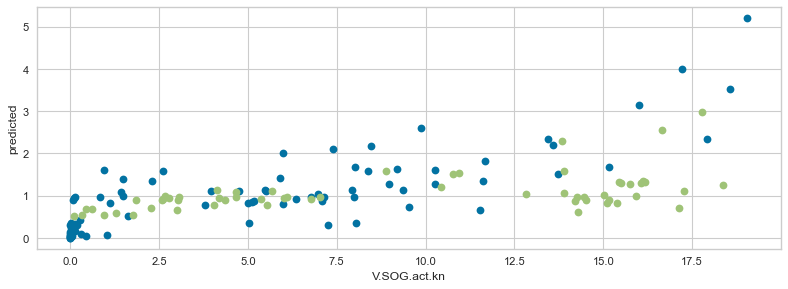

In [181]:
fig=plt.figure(figsize=(12, 4), dpi=80)
sns.scatterplot(data = df_residual_high_neg, 
                x = 'V.SOG.act.kn', 
                y = 'predicted',
                linewidth=0
                )
sns.scatterplot(data = df_residual_high_pos, 
                x = 'V.SOG.act.kn', 
                y = 'predicted',
                linewidth=0
                )

<AxesSubplot:xlabel='Power_EM_predict', ylabel='predicted'>

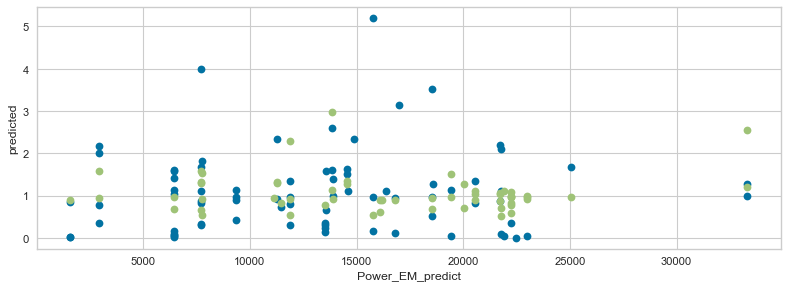

In [180]:
fig=plt.figure(figsize=(12, 4), dpi=80)
sns.scatterplot(data = df_residual_high_neg, 
                x = 'Power_EM_predict', 
                y = 'predicted',
                linewidth=0
                )
sns.scatterplot(data = df_residual_high_pos, 
                x = 'Power_EM_predict', 
                y = 'predicted',
                linewidth=0
                )

<AxesSubplot:xlabel='ME.SFCI.act.gPkWh', ylabel='predicted'>

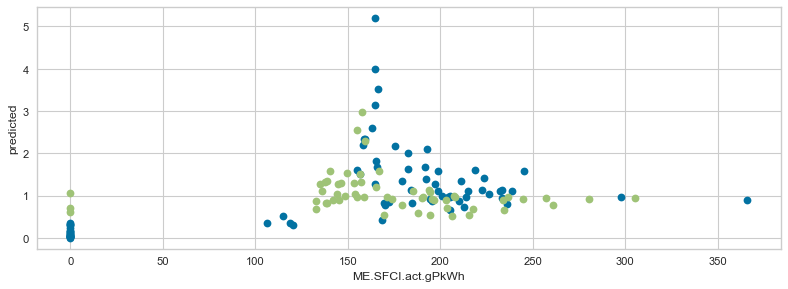

In [182]:
fig=plt.figure(figsize=(12, 4), dpi=80)
sns.scatterplot(data = df_residual_high_neg, 
                x = 'ME.SFCI.act.gPkWh', 
                y = 'predicted',
                linewidth=0
                )
sns.scatterplot(data = df_residual_high_pos, 
                x = 'ME.SFCI.act.gPkWh', 
                y = 'predicted',
                linewidth=0
                )

<AxesSubplot:xlabel='V.SLPOG.act.PRC', ylabel='predicted'>

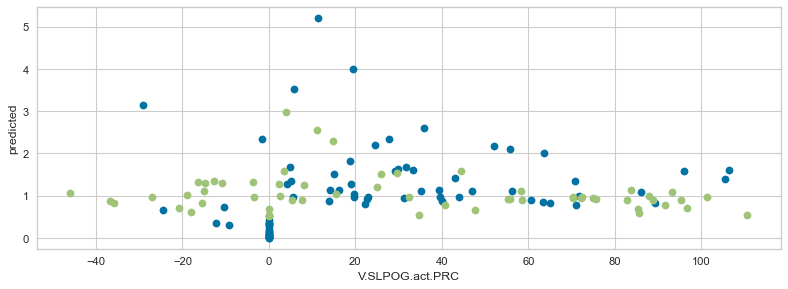

In [183]:
fig=plt.figure(figsize=(12, 4), dpi=80)
sns.scatterplot(data = df_residual_high_neg, 
                x = 'V.SLPOG.act.PRC', 
                y = 'predicted',
                linewidth=0
                )
sns.scatterplot(data = df_residual_high_pos, 
                x = 'V.SLPOG.act.PRC', 
                y = 'predicted',
                linewidth=0
                )

<AxesSubplot:xlabel='V.COG.act.deg', ylabel='predicted'>

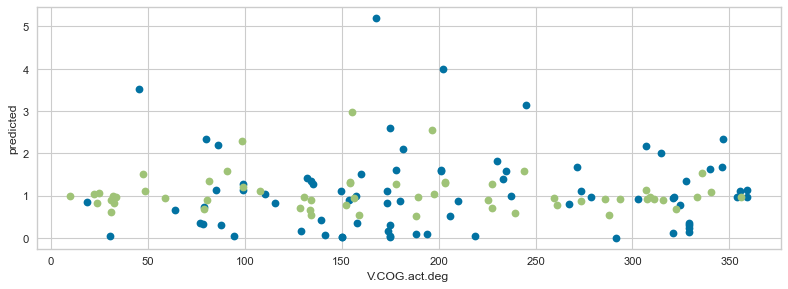

In [184]:
fig=plt.figure(figsize=(12, 4), dpi=80)
sns.scatterplot(data = df_residual_high_neg, 
                x = 'V.COG.act.deg', 
                y = 'predicted',
                linewidth=0
                )
sns.scatterplot(data = df_residual_high_pos, 
                x = 'V.COG.act.deg', 
                y = 'predicted',
                linewidth=0
                )

<AxesSubplot:xlabel='V.GPSLON.act.deg', ylabel='predicted'>

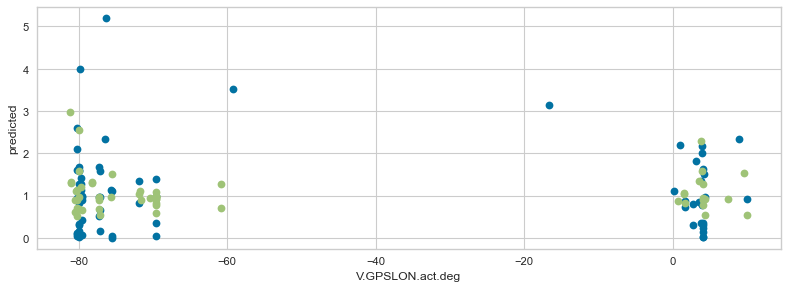

In [185]:
fig=plt.figure(figsize=(12, 4), dpi=80)
sns.scatterplot(data = df_residual_high_neg, 
                x = 'V.GPSLON.act.deg', 
                y = 'predicted',
                linewidth=0
                )
sns.scatterplot(data = df_residual_high_pos, 
                x = 'V.GPSLON.act.deg', 
                y = 'predicted',
                linewidth=0
                )

<AxesSubplot:xlabel='V.GPSLAT.act.deg', ylabel='predicted'>

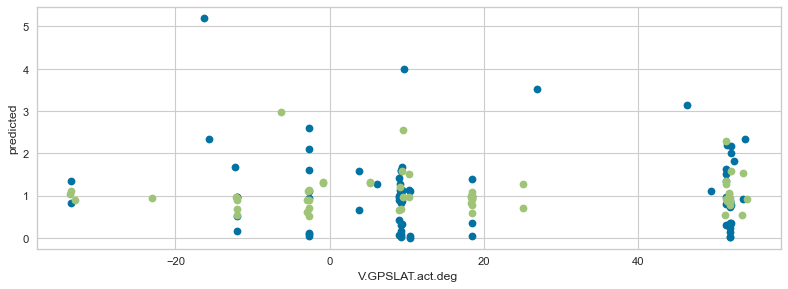

In [187]:
fig=plt.figure(figsize=(12, 4), dpi=80)
sns.scatterplot(data = df_residual_high_neg, 
                x = 'V.GPSLAT.act.deg', 
                y = 'predicted',
                linewidth=0
                )
sns.scatterplot(data = df_residual_high_pos, 
                x = 'V.GPSLAT.act.deg', 
                y = 'predicted',
                linewidth=0
                )